# ETH Shock Analysis

## Purpose
Expore how diffenent statues(liquidation ratios, liquidity, surplus, etc) affect the risk of bad-debt creation in the Reflexer system by simulating *instantaneous* ETH/USD shocks.
To examine historical ETH shocks see [Historical ETH Shocks](<Historical ETH Shocks.ipynb>)

#### Note: Same as [ETH Shock Simulations and System Debt](<ETH Shock Simulations and System Debt.ipynb>) but uses liquidity-to-debt ratios instead of absolute liquidity amounts.

In [1]:
import time
import math
import pandas as pd
import numpy as np
import requests
import json
import multiprocess
from multiprocess import Pool
from decimal import Decimal
import matplotlib.pyplot as plt
import scipy.stats as ss
from sklearn.preprocessing import PowerTransformer
from web3 import Web3, HTTPProvider

from scipy.stats import multivariate_normal

import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

from uniswap import get_input_price, get_output_price, buy_to_price
from graph_util import fetch_safes, fetch_rp, fetch_debt_ceiling, fetch_saviour_safes
from web3_util import fetch_saviour_targets
from util import chunks

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 

## Define Some Sim Functions

In [3]:
def update_cratios(safes, eth_price, redemption_price):
    # update c-ratio based on `eth_price` and `redemption_price`
    new_safes = safes.copy()
    new_safes['cratio'] = new_safes['collateral'] * eth_price / (new_safes['debt'] * redemption_price)
    return new_safes

In [4]:
def liquidate_critical(safes, liq_cratio=1.40):
    # Return amount of collateral/debt liquidated
    critical_safes = safes.query(f'cratio < {liq_cratio}')

    critical_collateral = critical_safes['collateral'].sum()
    critical_debt = critical_safes['debt'].sum()

    return critical_collateral, critical_debt

def adjust_safe_debt_and_cratios(safes, debt_adj, eth_price, redemption_price):
    # adjust debt by `debt_adj` multiplier
    if debt_adj == 1:
        return safes
    new_safes = safes.copy()
    
    new_safes['debt'] *= debt_adj

    return update_cratios(new_safes, eth_price, redemption_price)

## Fetch Data

In [5]:
#graphql_url = 'https://subgraph.reflexer.finance/subgraphs/name/reflexer-labs/rai'
graphql_url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'
eth_usd_url = 'https://api.coingecko.com/api/v3/simple/price?ids=ethereum&vs_currencies=usd'
ETH_RPC_URL = 'https://mainnet.infura.io/v3/71de86fb79e940a7970bad3f43c0da4e'

web3 = Web3(HTTPProvider(endpoint_uri=ETH_RPC_URL))

ETH_USD = requests.get(eth_usd_url).json()['ethereum']['usd']
REDEMPTION_PRICE = fetch_rp(graphql_url)
DEBT_CEILING = fetch_debt_ceiling(graphql_url)

# get saviour safes from graph
saviour_safes = fetch_saviour_safes(graphql_url)

# get LP info not available in graph
saviour_safes = fetch_saviour_targets(web3, saviour_safes)

orig_safes = fetch_safes(graphql_url)

In [6]:
orig_safes.head(5)

,collateral,debt,safeId
0,0.0,0.0,1133
1,0.0,0.0,1753
2,0.0,0.0,878
3,0.0,0.0,1352
4,0.0,0.0,1927


In [7]:
print(update_cratios(saviour_safes, ETH_USD, REDEMPTION_PRICE).head(5))

   collateral           debt                                 safeHandler  \
0  320.750000  300267.718816  0x04ede7c03a6d7512ae80a9c87b54086433336e61   
1  110.000000   70517.081190  0x06b5db60cb55d25805e47afe685dbb6bf04bd87d   
2    4.000000    1741.480565  0x4a338e3dddcd442b0e84b7dd694d189a4c997c31   
3   46.926257   19170.302036  0x4a7dc7aa0a0148d9c29ded518c11674561c5573f   
4   70.500000   33515.826113  0x51d5cba742f29ebde1c28cf46aafb5ef2a866a8f   

  safeId  target_cratio    lp_syscoin  lp_collateral    cratio  
0    544            165  58557.474739      38.699870  1.627277  
1   1755            165  33461.414137      22.114212  2.376303  
2   1619            175   1586.038922       1.048192  3.499007  
3   1392            165   5228.345959       3.455346  3.728983  
4     67            200  16420.604074      10.852163  3.204370  


In [8]:
# only consider SAFEs with debt
orig_safes = orig_safes.query('debt > 0').reset_index(drop=True)
saviour_safes = saviour_safes.query('debt > 0').reset_index(drop=True)

# Extra debt and collateral that can be created if debt ceiling is exhausted(use system c-ratio)
extra_debt = DEBT_CEILING  - orig_safes['debt'].sum()

In [9]:
orig_safes['safeId'] = orig_safes['safeId'].astype(int)
saviour_safes['safeId'] = saviour_safes['safeId'].astype(int)

In [10]:
both_safes = pd.merge(orig_safes, saviour_safes, on='safeId', how='outer', indicator=True)
non_saviour_safes = both_safes.query('_merge == "left_only"').reset_index(drop=True)\
                    .rename({'collateral_x': 'collateral', 'debt_x': 'debt'}, axis=1)\
                    [['collateral', 'debt', 'safeId']]
print(non_saviour_safes['collateral'].sum(), orig_safes['collateral'].sum())

48397.076067040834 49851.02350895079


## Mainnet Parameters

In [11]:
MAINNET_LIQ_RATIO = 1.35 
LIQ_PENALTY = 1.10
INITIAL_SURPLUS = 491000
MIN_DISCOUNT = 0.92
MAX_DISCOUNT = 0.90

# use max_discount for collateral_auctions
DISCOUNT = MAX_DISCOUNT

# What percent of SAFE owners avoid liquidation with OSM delay
OSM_RESPONSIVENESS = 0.50 

# Pct of collateral w/ saviours
#SAVIOUR_COLLATERAL = 0.15

# RAI pools
RAI_ETH_V2= 5.4E6
RAI_ETH_V3 = 26.3E3 
RAI_DAI_V3 = 1.38E6 
RAI_USDC_V3 = 16.6E3 

rai_v2_pool = RAI_ETH_V2 + RAI_ETH_V3
usd_v2_pool = rai_v2_pool * REDEMPTION_PRICE

rai_v3_pool = RAI_DAI_V3 + RAI_USDC_V3
usd_v3_pool = rai_v3_pool * REDEMPTION_PRICE

#### Not currently used
SURPLUS_BUFFER = 500000 # Not currently used
DISCOUNT_UPDATE_RATE = Decimal(0.999991859697312485818842992) # Not currently used
LIQUIDATION_QUANTITY = 90000.00 # Not currently used
ON_AUCTION_SYSTEM_COIN_LIMIT = 4025086.73 # Not currently used
#####


## Sim Parameters

In [12]:
N_RUNS = 100
N_SHOCK_RUNS = 50
LRS = [1.35]

V2_POOL_DEBTS = np.round(np.linspace(0.05, 0.70, 14), 3)
V3_POOL_DEBTS = np.zeros(V2_POOL_DEBTS.shape)
SURPLUSES = [500E3]

min_shock = 0.20
max_shock = 0.50
n_shocks = 31
SHOCKS = np.round(np.linspace(min_shock, max_shock, n_shocks), 4)
TOTAL_SHOCKS = [1]

# Analysis Parameters
QUANTILES = [0.95]

In [13]:
V2_POOL_DEBTS

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 ])

## Overview

Explore bad debt creation during ETH/USD price dops.

## Methodology

Simulate an ETH/USD price drop of X%, then use RAI from Uniswap pools to settle resulting collateral auction and determine how much bad debt is created.

## Simulations

#### 1) Mainnet collateral amounts and c-ratios

#### 2) Mainnet collateral amounts and stochastic c-ratios

#### 3) Stochastic collateral amounts and stochastic c-ratios

#### 4) Gaussian Mixture model for collateral amounts and c-ratios


## Pessimistic Assumptions
### 1) All RAI for collateral auctions is purchased from market. No RAI-holding keepers exist
### 2) Overly expensive RAI market price.  Keepers get worse deal for RAI than expected and can buy less collateral at a profit.
####     - No RAI market selling pressure when keepers purchase RAI -> expensive RAI

### 3) Saviours not considered
### 4) V2 Pool liquidity is reduced by 50% for all shocks
### 5) 50% OSM Responsiveness to avoid liquidation
### 6) Uses static surplus. Doesn't reduce surplus over time due to negative SF

## Optimistic Assumptions
### 1) Gas price is not considered
### 2) Keeper efficiency not considered

In [14]:
# run a single sim
def run(orig_safes, saviour_safes, liq_ratio, rai_v2_pool,
        rai_v3_pool, shock, initial_surplus, rai_shock=0, verbose=False):
    
    # Set eth shock price
    eth_shock_price = ETH_USD * (1 + shock)
    
    # update c-ratios
    safes = update_cratios(orig_safes, eth_shock_price, REDEMPTION_PRICE)
    
    if len(saviour_safes) > 0:
        saviour_safes = update_cratios(saviour_safes, eth_shock_price, REDEMPTION_PRICE)  
        
        # total syscoin removed from pool by saviours        
        syscoin_lp = saviour_safes[saviour_safes['cratio'] < liq_ratio]['lp_syscoin'].sum()
        rai_v2_pool_left = rai_v2_pool - syscoin_lp
    else:
        rai_v2_pool_left = rai_v2_pool 

    # Liquidate all critical SAFEs
    critical_collateral, critical_debt = liquidate_critical(safes, liq_ratio)
    
    #critical_collateral *= (1 - SAVIOUR_COLLATERAL)
    #critical_debt *= (1 - SAVIOUR_COLLATERAL)
       
    critical_collateral *= (1 - OSM_RESPONSIVENESS)
    critical_debt *= (1 - OSM_RESPONSIVENESS)
      
    if verbose:
        print(f"{critical_collateral=:.0f}, {critical_debt:.0f}, ratio {critical_collateral/critical_debt:.2f}")
    
    amount_to_raise = critical_debt * LIQ_PENALTY
    discount_collateral_price = eth_shock_price * DISCOUNT
    
    total_collateral_cost = critical_collateral * discount_collateral_price
    
    # Use v3 pool 
    
    # Assume rai market = redemption price and estimate slippage
    rai_v3_market_price = REDEMPTION_PRICE * 1.005 # Estimate slippage in V3 pool.

    # Use up to the entire pool to buy discounted collateral
    v3_collateral_bought = min((rai_v3_pool * REDEMPTION_PRICE)/discount_collateral_price, critical_collateral) 

    collateral_left = critical_collateral - v3_collateral_bought

    rai_v3_spent = v3_collateral_bought * discount_collateral_price / REDEMPTION_PRICE

    amount_raised_v3 = rai_v3_spent

    if verbose:
        print(f"{amount_raised_v3=:0f}")
        
    if collateral_left == 0:
        amount_deficit = critical_debt - amount_raised_v3

    else: # then use V2 pool

        amount_left_to_raise = amount_to_raise - rai_v3_spent
        
        if verbose:
            print(f"Using V2 pool. {amount_left_to_raise=:.0f}")
            
        collateral_left_cost = collateral_left * discount_collateral_price

        # max price to pay for RAI to make a profit on discounted collateral
        max_market_price = REDEMPTION_PRICE / DISCOUNT
        
        current_market_price = REDEMPTION_PRICE * (1 + rai_shock)
        #print(f"{current_market_price=}")

        # Max amount to buy to put cost-basis at `max_market_price`
        how_much_v2_can_buy = 2 * buy_to_price(None, rai_v2_pool_left,
                                               goal_price=max_market_price,
                                               market_price=current_market_price)
                                               #market_price=REDEMPTION_PRICE)
        
        # how is the pool affected when with this swap
        # This just confirms the expected final market price
        #delta_usd, delta_rai = get_output_price(how_much_v2_can_buy, usd_v2_pool, rai_v2_pool, trade_fee=0.003)
        # new market price
        #print(f"market price after buy {(usd_v2_pool + delta_usd)/(rai_v2_pool + delta_rai):.2f}")

        amount_raised_v2 = min(amount_left_to_raise, how_much_v2_can_buy)

        amount_deficit = critical_debt - amount_raised_v2 - amount_raised_v3
        #print(f"{how_much_v2_can_buy=:2f}, {amount_raised_v2=:2f}, {amount_deficit=:2f}")

    if verbose:
        print(f"{amount_deficit=:2f}")
        
    return initial_surplus - amount_deficit

In [15]:
# run a single sim
def run2(safes, saviour_safes, liq_ratio, rai_v2_pool,
        rai_v3_pool, eth_shock_price, initial_surplus, rai_shock=0, verbose=False):
    
    # Set eth shock price
    #eth_shock_price = ETH_USD * (1 + shock)
    
    # update c-ratios
    #safes = update_cratios(orig_safes, eth_shock_price, REDEMPTION_PRICE)
    
    
    if len(saviour_safes) > 0:
        #saviour_safes = update_cratios(saviour_safes, eth_shock_price, REDEMPTION_PRICE)  
        
        # total syscoin removed from pool by saviours        
        syscoin_lp = saviour_safes[saviour_safes['cratio'] < liq_ratio]['lp_syscoin'].sum()
        rai_v2_pool_left = rai_v2_pool - syscoin_lp
    else:
        rai_v2_pool_left = rai_v2_pool 

    # Liquidate all critical SAFEs
    critical_collateral, critical_debt = liquidate_critical(safes, liq_ratio)
    
    #critical_collateral *= (1 - SAVIOUR_COLLATERAL)
    #critical_debt *= (1 - SAVIOUR_COLLATERAL)
       
    critical_collateral *= (1 - OSM_RESPONSIVENESS)
    critical_debt *= (1 - OSM_RESPONSIVENESS)
      
    if verbose:
        print(f"{critical_collateral=:.0f}, {critical_debt:.0f}, ratio {critical_collateral/critical_debt:.2f}")
    
    amount_to_raise = critical_debt * LIQ_PENALTY
    discount_collateral_price = eth_shock_price * DISCOUNT
    
    total_collateral_cost = critical_collateral * discount_collateral_price
    
    # Use v3 pool 
    
    # Assume rai market = redemption price and estimate slippage
    rai_v3_market_price = REDEMPTION_PRICE * 1.005 # Estimate slippage in V3 pool.

    # Use up to the entire pool to buy discounted collateral
    v3_collateral_bought = min((rai_v3_pool * REDEMPTION_PRICE)/discount_collateral_price, critical_collateral) 

    collateral_left = critical_collateral - v3_collateral_bought

    rai_v3_spent = v3_collateral_bought * discount_collateral_price / REDEMPTION_PRICE

    amount_raised_v3 = rai_v3_spent

    if verbose:
        print(f"{amount_raised_v3=:0f}")
        
    if collateral_left == 0:
        amount_deficit = critical_debt - amount_raised_v3

    else: # then use V2 pool

        amount_left_to_raise = amount_to_raise - rai_v3_spent
        
        if verbose:
            print(f"Using V2 pool. {amount_left_to_raise=:.0f}")
            
        collateral_left_cost = collateral_left * discount_collateral_price

        # max price to pay for RAI to make a profit on discounted collateral
        max_market_price = REDEMPTION_PRICE / DISCOUNT
        
        current_market_price = REDEMPTION_PRICE * (1 + rai_shock)
        #print(f"{current_market_price=}")

        # Max amount to buy to put cost-basis at `max_market_price`
        how_much_v2_can_buy = 2 * buy_to_price(None, rai_v2_pool_left,
                                               goal_price=max_market_price,
                                               market_price=current_market_price)
                                               #market_price=REDEMPTION_PRICE)
        
        # how is the pool affected when with this swap
        # This just confirms the expected final market price
        #delta_usd, delta_rai = get_output_price(how_much_v2_can_buy, usd_v2_pool, rai_v2_pool, trade_fee=0.003)
        # new market price
        #print(f"market price after buy {(usd_v2_pool + delta_usd)/(rai_v2_pool + delta_rai):.2f}")

        amount_raised_v2 = min(amount_left_to_raise, how_much_v2_can_buy)

        amount_deficit = critical_debt - amount_raised_v2 - amount_raised_v3
        #print(f"{how_much_v2_can_buy=:2f}, {amount_raised_v2=:2f}, {amount_deficit=:2f}")

    if verbose:
        print(f"{amount_deficit=:2f}")
        
    return initial_surplus - amount_deficit

In [16]:
# run many sims over multiple subsequent shocks
def run_sims_iter(safes, n_shocks=5, title='', sim_name='', verbose=False, plot=False):
    assert len(safes) == N_RUNS
    all_shocks = []
    all_surplus = []
    all_results = []
    
    for v2_liq_debt, v3_liq_debt in zip(V2_POOL_DEBTS, V3_POOL_DEBTS):
        # `debt_adj` is used to adjust individual SAFE debt to match expected values when liq_ratio is changed
        # This preserves safe debt as a multiplier of liq_ratio
        debt_adj =  1
        lr_safes = [adjust_safe_debt_and_cratios(safe, debt_adj, ETH_USD, REDEMPTION_PRICE) for safe in safes]
        mean_debt_usd = np.mean([s['debt'].sum() for s in lr_safes])
        rai_v3_pool = v3_liq_debt * mean_debt_usd
        rai_v2_pool = v2_liq_debt * mean_debt_usd

        for initial_surplus in SURPLUSES:
            config_shocks = []
            config_surpluses = []
            
            for i in range(N_RUNS):
                run_safes = lr_safes[i]
                lr_surpluses = []               
                for s in SHOCKS:
                    total_shocks_run = 0
                    surplus = initial_surplus
                    while total_shocks_run < n_shocks:
                        surplus = run(run_safes, [], liq_ratio=MAINNET_LIQ_RATIO,
                                      rai_v2_pool=rai_v2_pool, rai_v3_pool=rai_v3_pool,
                                      shock=-s, initial_surplus=surplus)
                        total_shocks_run += 1 
                            
                    config_shocks.append(s)
                    config_surpluses.append(surplus)
                    
                    if s == 0.0 and surplus < 0:
                        raise ValueError("negative surplus at zero shock")
                    
                    all_shocks.append(s)
                    all_surplus.append(surplus)
                    
                    if plot:
                        lr_surpluses.append(surplus)

                if plot and N_RUNS < 100: # Plotting too many runs is slow
                    plt.plot(SHOCKS, lr_surpluses, alpha=0.1)

            df = pd.DataFrame({'sim_name': sim_name, 'lr':MAINNET_LIQ_RATIO, 'v2_liq_debt': v2_liq_debt, 'v3_liq_debt': v3_liq_debt, 'initial_surplus': initial_surplus, 
                               'shock': config_shocks,  'surplus': config_surpluses})
            
            all_results.append(df)
        
            for q in QUANTILES:
                if verbose:
                    df_q = df[['shock', 'surplus']].groupby('shock').quantile(1. - q).reset_index()
                    zero_q = df_q[df_q['surplus'] > 0].sort_values('surplus')
                    if len(zero_q) == 0:
                        continue
                    zero_debt_q = zero_q.iloc[0]['shock']
                    print(f"{sim_name=}, {v2_liq_debt=}, {v3_liq_debt=}, {initial_surplus=}, {q=}, {zero_debt_q=:.3f}")

                if plot and len(QUANTILES) <= 10:
                    df_100 = df[['shock', 'surplus']].groupby('shock').quantile(1.0).reset_index()
                    plt.plot(df_q['shock'], df_q['surplus'], ':')
                    plt.plot(df_100['shock'], df_100['surplus'], ':')
                    plt.fill_between(SHOCKS, 
                                df_100['surplus'], 
                                df_q['surplus'], alpha=0.4,label=f"{q*100}% confidence")

            if plot:
                df_mean = df[['shock', 'surplus']].groupby('shock').mean().reset_index()
                plt.plot(df_mean['shock'], df_mean['surplus'])
                plt.title(f'{title}\n{v2_liq_debt=}, {v3_liq_debt=}, {initial_surplus=} {N_RUNS=}', fontsize=14)
                plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
                plt.ylabel('Surplus', fontsize=16)
                plt.grid(True)
                plt.legend(loc='lower left')
                plt.ylim([-1E7,2E6])
                plt.show()
                
    return pd.concat(all_results)


In [17]:
def cond_dist(means, covs, a):
    # dist of x1 given x2=a
    # https://online.stat.psu.edu/stat505/lesson/6/6.1
    mu_1, mu_2 = means[0]
    cov_11 = covs[0][0, 0]
    cov_12 = covs[0][0, 1]
    cov_21 = covs[0][1, 0]
    cov_22 = covs[0][1, 1]
    
    mu_cond = + cov_12*(1/cov_22)*(a-mu_2)
    cov_cond = cov_11 - cov_12*(1/cov_22)*cov_21
    
    return mu_cond, cov_cond

In [18]:
# run many sims over multiple subsequent shocks
def run_sims_iter2(safes, shocks=[], rai_returns={}, title='', sim_name='', verbose=False, plot=False):
    assert len(safes) == N_RUNS
    #all_shocks = []
    #all_surplus = []
    all_results = []

    for v2_liq_debt, v3_liq_debt in zip(V2_POOL_DEBTS, V3_POOL_DEBTS):
        # `debt_adj` is used to adjust individual SAFE debt to match expected values when liq_ratio is changed
        # This preserves safe debt as a multiplier of liq_ratio
        #debt_adj =  1
        #lr_safes = [adjust_safe_debt_and_cratios(safe, debt_adj, ETH_USD, REDEMPTION_PRICE) for safe in safes]
        lr_safes = safes
        #mean_debt_usd = np.mean([s['debt'].sum() for s in lr_safes])
        #rai_v3_pool = v3_liq_debt * mean_debt_usd
        #rai_v2_pool = v2_liq_debt * mean_debt_usd
        for initial_surplus in SURPLUSES:
            config_shocks = []
            config_surpluses = []           
            for r in range(N_RUNS):
                run_safes = lr_safes[r]
                debt_usd = run_safes['debt'].sum()
                rai_v3_pool = v3_liq_debt * debt_usd
                rai_v2_pool = v2_liq_debt * debt_usd
                plot_surpluses = []  
                for s in shocks:
                    # Set eth shock price
                    eth_shock_price = ETH_USD * (1 + -s)
                    
                    # update c-ratios before run()
                    run_safes = update_cratios(run_safes, eth_shock_price, REDEMPTION_PRICE)

                    #if len(saviour_safes) > 0:
                    #saviour_safes = update_cratios(saviour_safes, eth_shock_price, REDEMPTION_PRICE)  
                                       
                    for rai_usd_shock in rai_returns[s]:
                        
                        run_surplus = run2(run_safes, [], liq_ratio=MAINNET_LIQ_RATIO,
                                          rai_v2_pool=rai_v2_pool, rai_v3_pool=rai_v3_pool,
                                          eth_shock_price=eth_shock_price, rai_shock=rai_usd_shock,
                                          initial_surplus=initial_surplus)
                        #print(f"{v2_liq_debt=}, {r=}, shock={-s}, {rai_usd_shock=:.2f}, {run_surplus=:.2f}")    
                        config_shocks.append(s)
                        config_surpluses.append(run_surplus)   
                
                        if s == 0.0 and run_surplus < 0:
                            raise ValueError("negative surplus at zero shock")
                    
                        if plot and N_RUNS <= 1000:
                             plot_surpluses.append(run_surplus)

                if plot and N_RUNS <= 1000: # Plotting too many runs is slow
                    plt.plot(np.repeat(shocks, N_SHOCK_RUNS), plot_surpluses, alpha=0.1)

            df = pd.DataFrame({'sim_name': sim_name, 'lr':MAINNET_LIQ_RATIO, 'v2_liq_debt': v2_liq_debt, 'v3_liq_debt': v3_liq_debt, 'initial_surplus': initial_surplus, 
                               'shock': config_shocks,  'surplus': config_surpluses})
            #all_results.append(df)
        
            for q in QUANTILES:
                if verbose:
                    df_q = df[['shock', 'surplus']].groupby('shock').quantile(1. - q).reset_index()
                    pos_surplus = df_q[df_q['surplus'] > 0].sort_values('surplus')
                    if len(pos_surplus) == 0: # all surpluses were negative
                        print(f"{sim_name=}, {v2_liq_debt=}, {v3_liq_debt=}, {initial_surplus=}, {q=}, all {q} pctiles of shocks are negative")
                        continue
                    first_pos_surplus = pos_surplus.iloc[0]['shock']
                    print(f"{sim_name=}, {v2_liq_debt=}, {v3_liq_debt=}, {initial_surplus=}, {q=}, {first_pos_surplus=:.3f}")

                if plot and len(QUANTILES) <= 10:
                    df_100 = df[['shock', 'surplus']].groupby('shock').quantile(1.0).reset_index()
                    plt.plot(df_q['shock'], df_q['surplus'], ':')
                    plt.plot(df_100['shock'], df_100['surplus'], ':')
                    plt.fill_between(SHOCKS, 
                                df_100['surplus'], 
                                df_q['surplus'], alpha=0.4,label=f"{q*100}% confidence")

            if plot:
                df_mean = df[['shock', 'surplus']].groupby('shock').mean().reset_index()
                plt.plot(df_mean['shock'], df_mean['surplus'])
                plt.title(f'{title}\n{v2_liq_debt=}, {v3_liq_debt=}, {initial_surplus=} {N_RUNS=}', fontsize=14)
                plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
                plt.ylabel('Surplus', fontsize=16)
                plt.grid(True)
                plt.legend(loc='lower left')
                plt.ylim([-1E7,2E6])
                plt.show()
                
    #return pd.concat(all_results)


# Sim #1: Mainnet SAFE Collateral Amounts and C-ratios

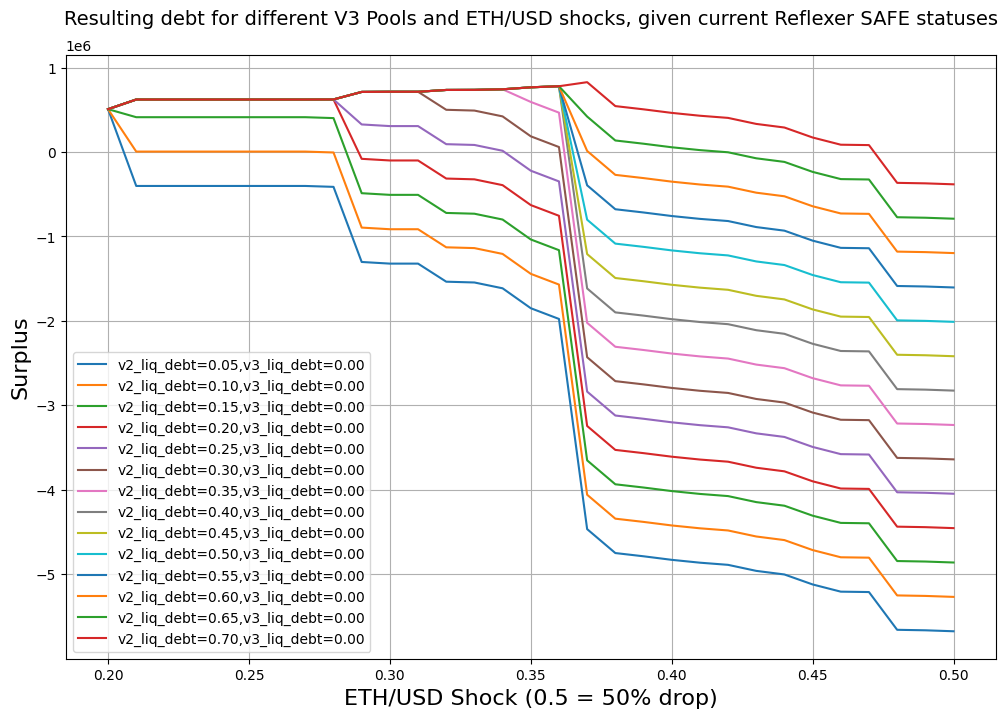

In [19]:
SHOCKS = np.round(np.linspace(min_shock, max_shock, n_shocks), 4)

for v2_liq_debt, v3_liq_debt in zip(V2_POOL_DEBTS, V3_POOL_DEBTS):    
    surpluses = []
    debt_adj =  MAINNET_LIQ_RATIO/ MAINNET_LIQ_RATIO
    safes = adjust_safe_debt_and_cratios(non_saviour_safes, debt_adj, ETH_USD, REDEMPTION_PRICE)
    total_debt_usd = safes['debt'].sum() * REDEMPTION_PRICE
    saviour_safes_adj = adjust_safe_debt_and_cratios(saviour_safes, debt_adj, ETH_USD, REDEMPTION_PRICE)
    all_debt_usd = total_debt_usd + saviour_safes_adj['debt'].sum() * REDEMPTION_PRICE
    for s in SHOCKS:
        #surplus = run(safes, saviour_safes_adj, lr, s, initial_surplus=INITIAL_SURPLUS, verbose=False)
        
        surplus = run(safes, [], liq_ratio=MAINNET_LIQ_RATIO, rai_v2_pool=v2_liq_debt*all_debt_usd, 
                      rai_v3_pool=v3_liq_debt*all_debt_usd, shock=-s, initial_surplus=INITIAL_SURPLUS, verbose=False)
        #print(f"{s=}, {surplus=}")
        #print(f"{lr=}, {s=}, {surplus=}")
        surpluses.append(surplus)
    plt.plot(SHOCKS, surpluses, label=f"{v2_liq_debt=:.2f},{v3_liq_debt=:.2f}")
    
plt.legend()
plt.title('Resulting debt for different V3 Pools and ETH/USD shocks, given current Reflexer SAFE statuses\n', fontsize=14)
plt.xlabel('ETH/USD Shock (0.5 = 50% drop)', fontsize=16)
plt.ylabel('Surplus', fontsize=16)
plt.grid(True)
plt.show()

## Compare Mainnet Saviour Safes to Non-Saviour

In [20]:
print(f"percent of mainnet collateral w/ saviours: {saviour_safes['collateral'].sum() /orig_safes['collateral'].sum():.2f}")

percent of mainnet collateral w/ saviours: 0.03


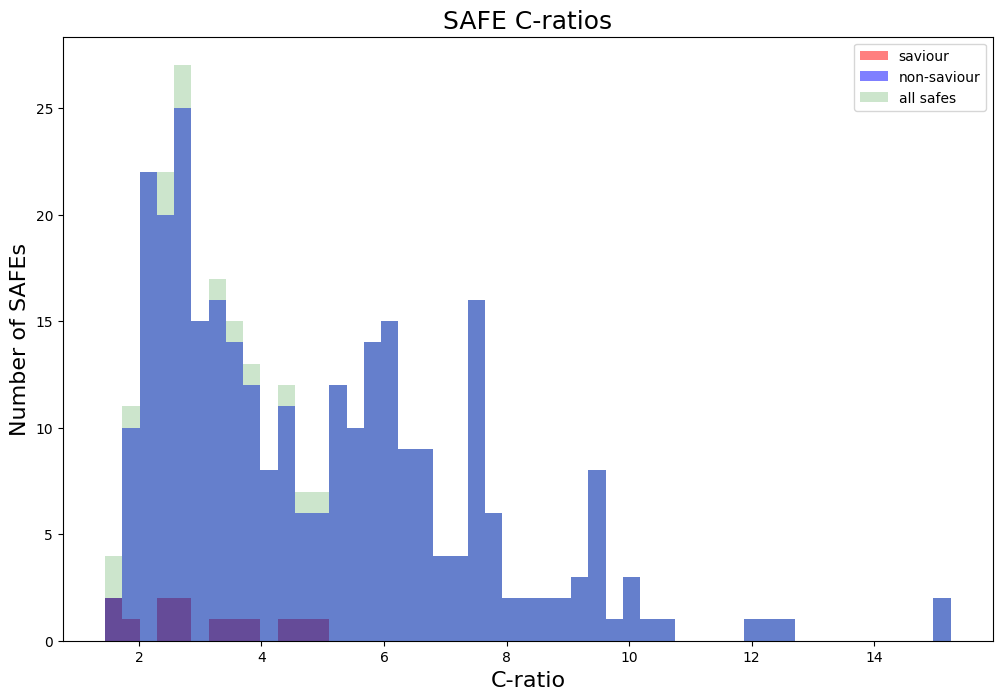

In [21]:
saviour_safes = update_cratios(saviour_safes, ETH_USD, REDEMPTION_PRICE)
non_saviour_safes = update_cratios(non_saviour_safes, ETH_USD, REDEMPTION_PRICE)

orig_safes = update_cratios(orig_safes, ETH_USD, REDEMPTION_PRICE)
bins = np.linspace(1.45, orig_safes['cratio'].max(), 50)

saviour_safes['cratio'].hist(bins=bins, alpha=0.5, color='red', label='saviour')

non_saviour_safes['cratio'].hist(bins=bins, color='blue', alpha=0.5, label='non-saviour')

orig_safes['cratio'].hist(bins=bins, color='green', alpha=0.2, label='all safes')

plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Sim #2: Mainnet SAFE Collateral Amounts with Stochastic C-ratios

### Examine mainnet c-ratios

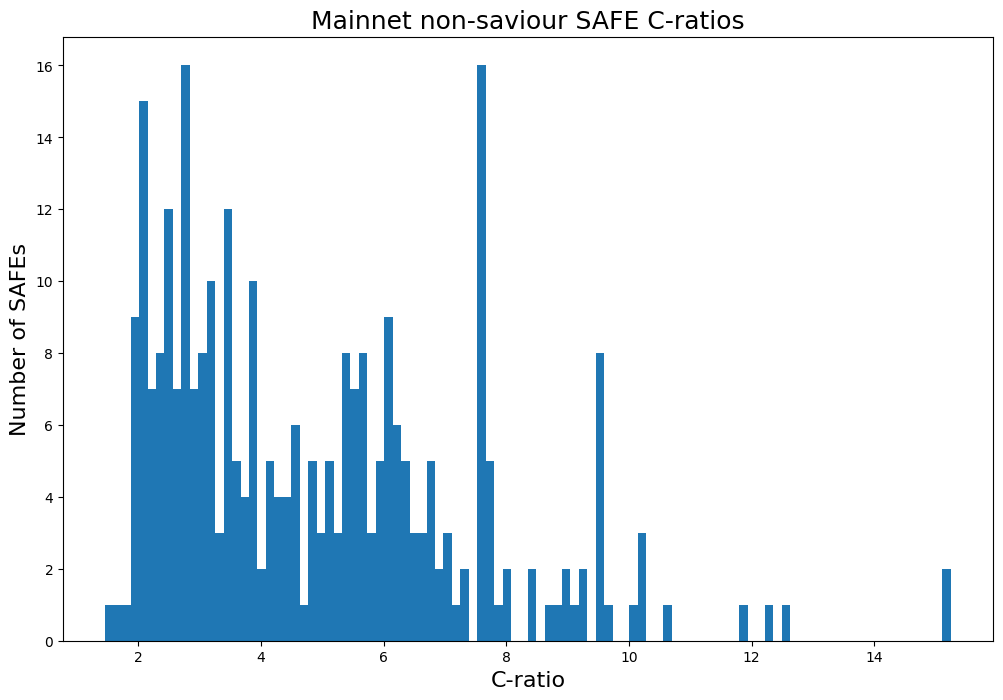

In [22]:
non_saviour_safes = update_cratios(non_saviour_safes, ETH_USD, REDEMPTION_PRICE)
non_saviour_safes['cratio'].hist(bins=100)
plt.title('Mainnet non-saviour SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.grid(False)
plt.show()

### Fit many distributions to mainnnet c-ratios

,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,0.372121,672.030861,-1959.881853,inf
skewnorm,0.383731,710.301694,-1950.787976,inf
exponnorm,0.384384,671.965900,-1950.284563,inf
johnsonsb,0.396896,682.752925,-1935.113225,inf
beta,0.415770,694.618188,-1921.361059,inf


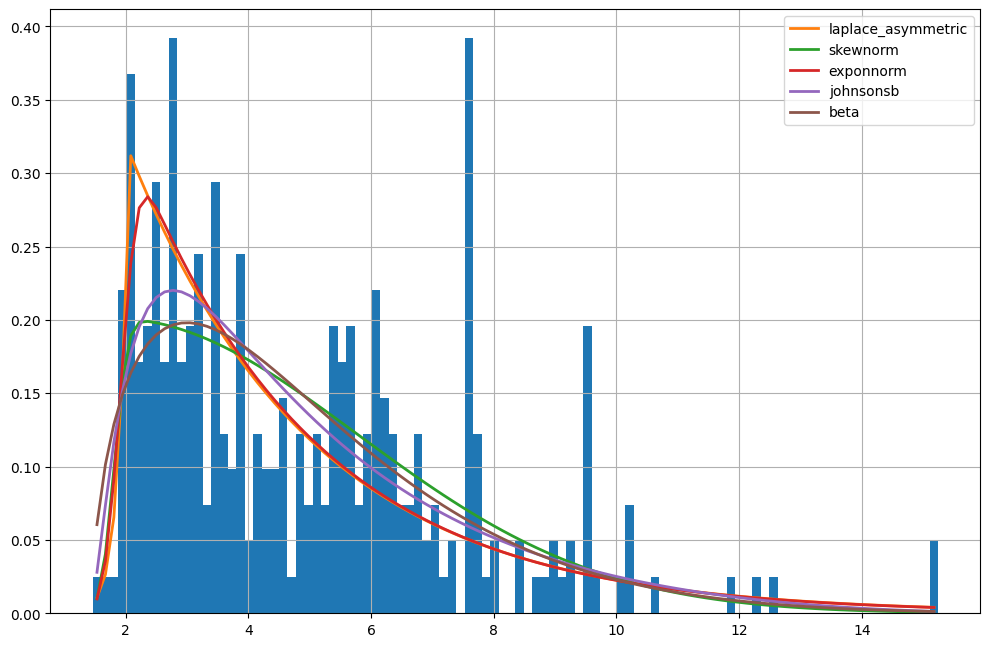

In [23]:
fitter_cratio = Fitter(non_saviour_safes['cratio'].values,
                       distributions=['skewnorm', 'exponnorm', 'johnsonsb', 'laplace_asymmetric', 'beta'])          
fitter_cratio.fit()
fitter_cratio.summary()

### Pick the best distribution and generate some c-ratios

In [24]:
# best_cratio = fitter_cratio.get_best(method = 'sumsquare_error')
cratio_params = fitter_cratio.fitted_param["skewnorm"]

In [25]:
non_saviour_safes['cratio'].head(20)

0      5.719896
1      8.769978
2      5.042044
3      4.048361
4      6.577488
5      2.683490
6      7.637561
7      2.439683
8      2.041284
9      1.461193
10     6.269509
11     7.669482
12    15.246095
13     3.609468
14     3.004090
15     9.563018
16    15.200698
17     3.082351
18     3.067438
19     5.523232
Name: cratio, dtype: float64

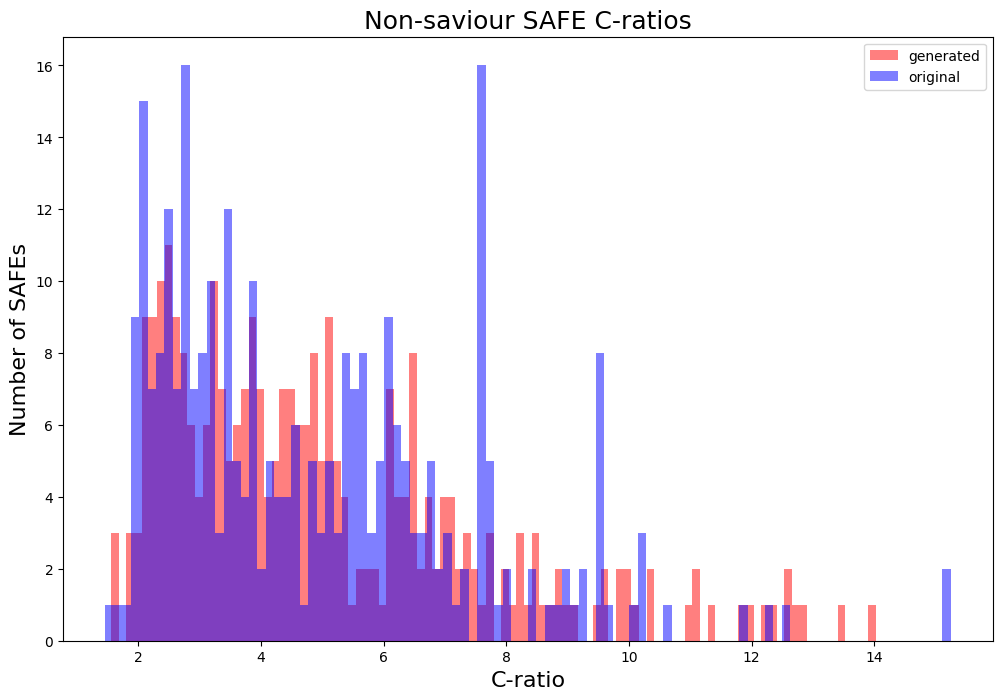

In [26]:
#cratios_r = ss.mielke.rvs(*cratio_params, size=len(non_saviour_safes)*2)
cratios_r = ss.skewnorm.rvs(*cratio_params, size=len(non_saviour_safes)*2)
cratios_r = cratios_r[cratios_r > MAINNET_LIQ_RATIO]

df = pd.DataFrame(cratios_r, columns=['cratio'])
df = df.head(len(non_saviour_safes))

df['cratio'].hist(bins=100, alpha=0.5, color='red', label='generated')

non_saviour_safes['cratio'].hist(bins=100, color='blue', alpha=0.5, label='original')

plt.title('Non-saviour SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Sim #2: Mainnet SAFE collateral amounts with stochastic c-ratios

### Prepare SAFEs

In [27]:
all_cratios = []
for _ in range(N_RUNS):
    #all_cratios.append(ss.mielke.rvs(*cratio_params, size=len(non_saviour_safes)*2))
    all_cratios.append(ss.skewnorm.rvs(*cratio_params, size=len(non_saviour_safes)*2))

cratio_rv = ss.mielke(*cratio_params)
cratio_rv = ss.skewnorm(*cratio_params)

all_tmp_safes = [pd.DataFrame(cr, columns=['cratio']) for cr in all_cratios]

final_sim2_safes = []
for tmp_safes in all_tmp_safes:
    tmp_safes = tmp_safes[tmp_safes['cratio'] > MAINNET_LIQ_RATIO]        
    tmp_safes = tmp_safes.head(len(non_saviour_safes))
    assert len(tmp_safes) == len(non_saviour_safes)

    tmp_safes['collateral'] = non_saviour_safes['collateral']
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']

    # Consider debt ceiling, adding more possible debt
    added_debt = 0
    while added_debt < extra_debt:
        new_cr = cratio_rv.rvs(size=1)[0]
        while new_cr < MAINNET_LIQ_RATIO: 
            new_cr = cratio_rv.rvs(size=1)[0]
            
        new_coll = non_saviour_safes['collateral'].sample().iloc[0]

        new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
        added_debt += new_debt
        tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
        
    final_sim2_safes.append(tmp_safes)        
    assert added_debt == extra_debt

# Sim #3: Stochastic SAFE collateral amounts and stochastic c-ratios

### Fit many distributions to mainnnet collateral amounts

,sumsquare_error,aic,bic,kl_div
laplace_asymmetric,1.775247,525.777518,-1497.389265,inf
skewcauchy,1.823149,560.468914,-1489.507967,inf
exponnorm,1.905524,521.483639,-1476.427232,inf
skewnorm,1.996559,509.091855,-1462.613433,inf
gausshyper,2.008390,488.956262,-1443.793574,inf


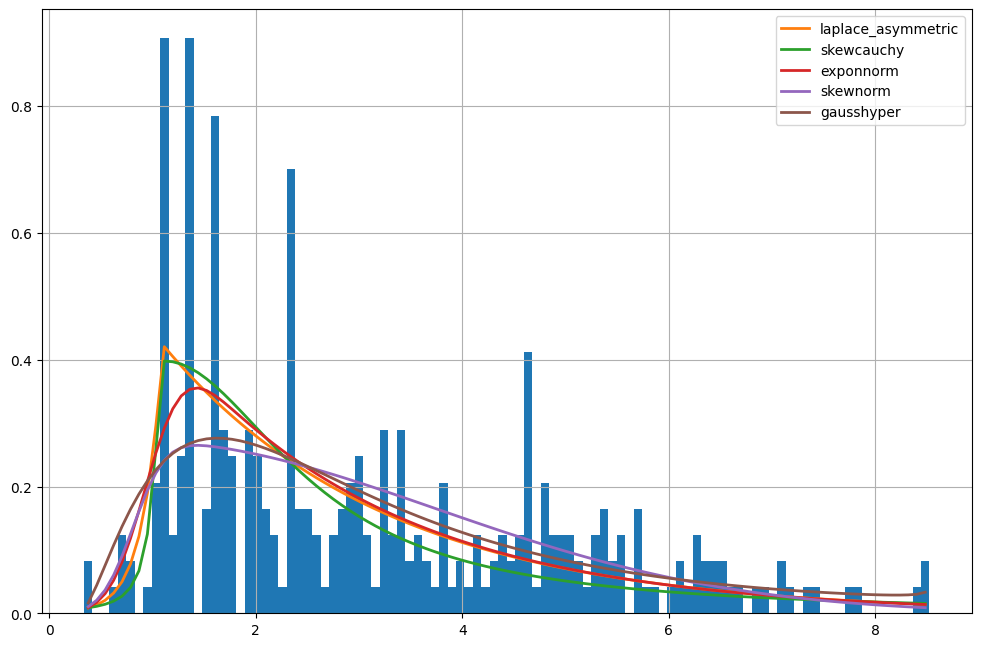

In [28]:
fitter_coll = Fitter(np.log(non_saviour_safes['collateral'].values),
                     distributions=['laplace_asymmetric', 'skewcauchy', 'exponnorm', 'gausshyper', 'skewnorm']) 
fitter_coll.fit()
fitter_coll.summary()

### Pick the best distribution and generate some collateral amounts

In [29]:
#best_coll = fitter_coll.get_best(method = 'sumsquare_error')
coll_params = fitter_coll.fitted_param["skewcauchy"]

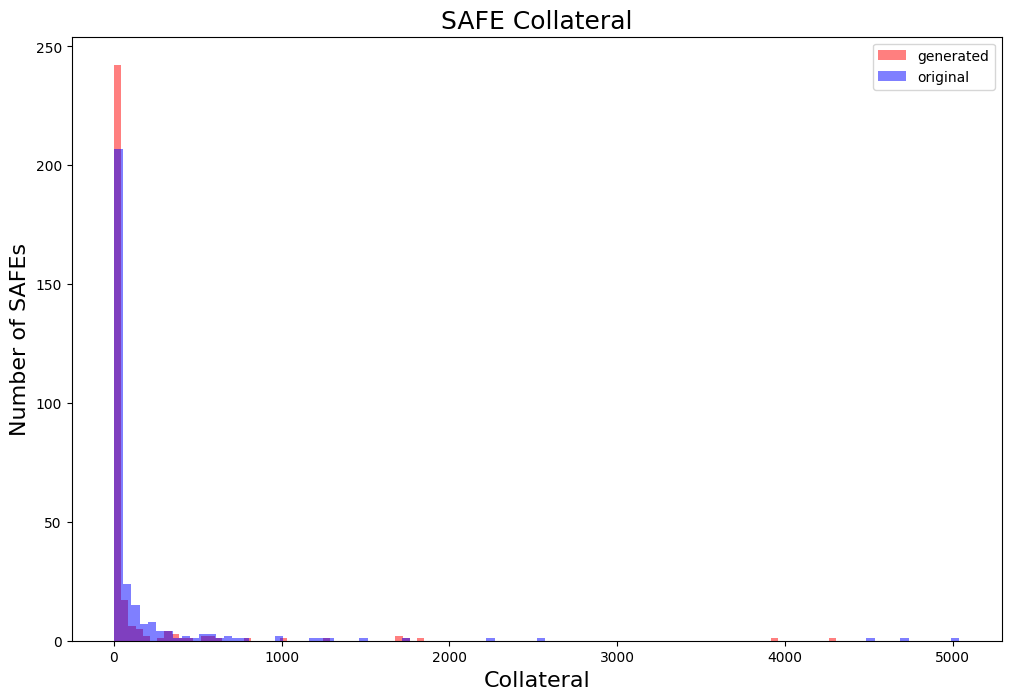

In [30]:
colls_r = ss.skewcauchy.rvs(*coll_params, size=len(non_saviour_safes)*2)

colls_r = np.exp(colls_r)

# Collateral

df = pd.DataFrame(colls_r, columns=['collateral'])
df = df[(df['collateral'] > 0) & (df['collateral'] < non_saviour_safes['collateral'].max()) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
df = df.head(len(non_saviour_safes))

df['collateral'].hist(bins=100, alpha=0.5, color='red', label='generated')

non_saviour_safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
#plt.xlim([0, 1000])
plt.title('SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

### Sim #3: Prepare SAFEs

In [31]:
all_cratios = []
for _ in range(N_RUNS):
    #all_cratios.append(ss.mielke.rvs(*cratio_params, size=len(non_saviour_safes)*2))
    all_cratios.append(ss.skewnorm.rvs(*cratio_params, size=len(non_saviour_safes)*2))
    
all_collaterals = []
for _ in range(N_RUNS):
    all_collaterals.append(np.exp(ss.skewcauchy.rvs(*coll_params, size=len(non_saviour_safes)*2)))
    
#cratio_rv = ss.mielke(*cratio_params)
cratio_rv = ss.skewnorm(*cratio_params)
coll_rv = ss.skewcauchy(*coll_params)

all_tmp_safes = [pd.DataFrame({'collateral': coll, 'cratio': cr})  for coll, cr in zip(all_collaterals, all_cratios)]

final_sim3_safes = []
for tmp_safes in all_tmp_safes:
    tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['collateral'] < non_saviour_safes['collateral'].max()) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
    tmp_safes = tmp_safes.head(len(non_saviour_safes))
    assert len(tmp_safes) == len(non_saviour_safes)
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']
    added_debt = 0
    while added_debt < extra_debt:
        # Sample c-ratios and collateral amounts
        new_cr = cratio_rv.rvs(size=1)[0]
        while new_cr < MAINNET_LIQ_RATIO: 
            new_cr = cratio_rv.rvs(size=1)[0]
            
        new_coll = np.exp(coll_rv.rvs(size=1))[0]
                 
        # calculate debt
        new_debt = min(new_coll * ETH_USD / REDEMPTION_PRICE / new_cr, extra_debt - added_debt)
        added_debt += new_debt
                
        # Add new SAFE
        tmp_safes = tmp_safes.append({'cratio': new_cr, 'collateral': new_coll, 'debt': new_debt}, ignore_index=True)
        
    assert added_debt == extra_debt
    final_sim3_safes.append(tmp_safes)
    
    

# Sim #4: Gaussian Mixture Model for SAFE collateral amounts and c-ratios

/var/folders/z_/tzvx3mfs7rsbb8dxt0rd157w0000gn/T/ipykernel_40468/863596043.py:37: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  CB = plt.colorbar(CS, shrink=0.8, extend='both')


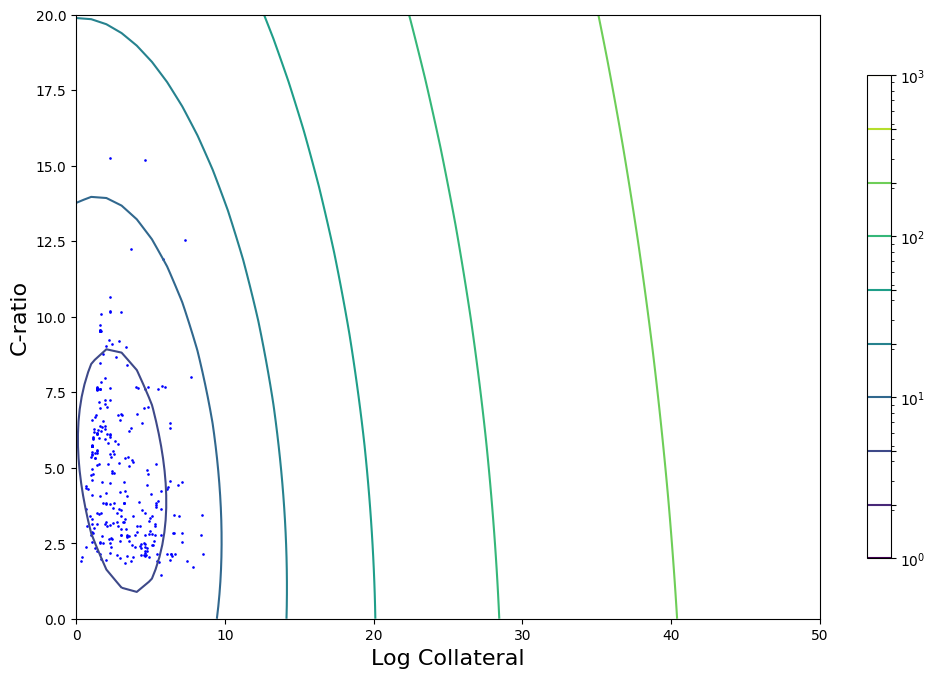

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

# Create a Gaussian Mixture Model with one component
clf = mixture.GaussianMixture(n_components=1, covariance_type='full')

safes = non_saviour_safes.copy()

# Transform collateral to make it normal
#pt = PowerTransformer()
#safes['collateral'] = pt.fit_transform(safes['collateral'].values.reshape(-1,1))
safes['collateral'] = np.log(safes['collateral'])

"""
safes['collateral'].hist(bins=100, color='blue', alpha=0.5, label='original')
plt.title('Transformed collateral')
plt.legend()
plt.grid(False)
plt.show()
"""

# Fit
clf.fit(safes[['collateral', 'cratio']])

# display predicted scores by the model as a contour plot
x = np.linspace(0, 50.)
y = np.linspace(0, 20.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')

plt.scatter(safes['collateral'], safes['cratio'], .8, color='blue')

#plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.xlabel('Log Collateral', fontsize=16)
plt.ylabel('C-ratio', fontsize=16)
plt.show()


In [33]:
"""
# C-ratios
sample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(non_saviour_safes)*2)
df = pd.DataFrame(sample, columns=['collateral', 'cratio'])
df = df[df['cratio'] > MAINNET_LIQ_RATIO]
df = df.head(len(non_saviour_safes))

bins = np.linspace(1.45, 14, 50)
df['cratio'].hist(bins=bins, alpha=0.5, color='red', label='generated')
non_saviour_safes['cratio'].hist(bins=bins, color='blue', alpha=0.5, label='original non-saviour-safes')

plt.title('SAFE C-ratios', fontsize=18)
plt.xlabel('C-ratio', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

# Collateral
sample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(non_saviour_safes)*2)
df = pd.DataFrame(sample, columns=['collateral', 'cratio'])
df = df[df['cratio'] > MAINNET_LIQ_RATIO]
df = df.head(len(non_saviour_safes))

df['collateral'] = np.exp(df['collateral'])

bins = np.linspace(0, 1000, 50)
df['collateral'].hist(bins=bins, alpha=0.5, color='red', label='generated')

non_saviour_safes['collateral'].hist(bins=bins, alpha=0.5, color='blue', label='original')
plt.xlim([0, 1000])
plt.title('non-saviour SAFE Collateral', fontsize=18)
plt.xlabel('Collateral', fontsize=16)
plt.ylabel('Number of SAFEs', fontsize=16)
plt.legend()
plt.grid(False)
plt.show()

"""

"\n# C-ratios\nsample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(non_saviour_safes)*2)\ndf = pd.DataFrame(sample, columns=['collateral', 'cratio'])\ndf = df[df['cratio'] > MAINNET_LIQ_RATIO]\ndf = df.head(len(non_saviour_safes))\n\nbins = np.linspace(1.45, 14, 50)\ndf['cratio'].hist(bins=bins, alpha=0.5, color='red', label='generated')\nnon_saviour_safes['cratio'].hist(bins=bins, color='blue', alpha=0.5, label='original non-saviour-safes')\n\nplt.title('SAFE C-ratios', fontsize=18)\nplt.xlabel('C-ratio', fontsize=16)\nplt.ylabel('Number of SAFEs', fontsize=16)\nplt.legend()\nplt.grid(False)\nplt.show()\n\n# Collateral\nsample = np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(non_saviour_safes)*2)\ndf = pd.DataFrame(sample, columns=['collateral', 'cratio'])\ndf = df[df['cratio'] > MAINNET_LIQ_RATIO]\ndf = df.head(len(non_saviour_safes))\n\ndf['collateral'] = np.exp(df['collateral'])\n\nbins = np.linspace(0, 1000, 50)\ndf['collateral'].h

## Sim #4: Prepare SAFEs

In [34]:
# Generate a population of SAFEs for each run

# draw random collateral and c-ratio values from distribution
all_gaussian_safes = [np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], len(non_saviour_safes)*2) for _ in range(N_RUNS)]

# Intialize SAFEs with random values
all_safes = [pd.DataFrame(gaussian_safe, columns=['collateral', 'cratio']) for gaussian_safe in all_gaussian_safes]

# Filter out unacceptable SAFEs
all_tmp_safes = []

for tmp_safes in all_safes:
    tmp_safes['collateral'] = np.exp(tmp_safes['collateral'])
    tmp_safes = tmp_safes[(tmp_safes['collateral'] > 0) & (tmp_safes['cratio'] > MAINNET_LIQ_RATIO)]
    
    tmp_safes = tmp_safes.head(len(non_saviour_safes))
    assert len(tmp_safes) == len(non_saviour_safes)
    
    tmp_safes['debt'] = tmp_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / tmp_safes['cratio']    
    all_tmp_safes.append(tmp_safes)
    
# Draw more random collateral and c-ratio values
all_extra_gaussian_safes = [np.random.multivariate_normal(clf.means_[0], clf.covariances_[0], 1000) for _ in range(N_RUNS)]

# Generate more SAFEs to fill up to debt ceiling
final_sim4_safes = []
for idx, gaussian_safes in enumerate(all_extra_gaussian_safes):
    new_safes = pd.DataFrame(gaussian_safes, columns=['collateral', 'cratio'])
    new_safes['collateral'] = np.exp(new_safes['collateral'])
    
     # Filter out unacceptable samples
    new_safes = new_safes[(new_safes['collateral'] > 0) & (new_safes['cratio'] > MAINNET_LIQ_RATIO)]
    
    # Calculate debt
    new_safes['debt'] = new_safes['collateral'] * ETH_USD / REDEMPTION_PRICE / new_safes['cratio']
    
    # Only use enough SAFEs to fill `extra_debt`
    new_safes['total_debt'] = new_safes['debt'].cumsum()        
    final_safes = new_safes[new_safes['total_debt'] <= extra_debt]
    assert len(final_safes) > 0
    
    final_safes.drop('total_debt', axis='columns')
    
    tmp_safes = pd.concat([all_tmp_safes[idx], final_safes])
    final_sim4_safes.append(tmp_safes)

# Prepare RAI/ETH Shocks

In [35]:
def prepare_rai_shocks(shocks, n):
    # from ETHUSD and RAIUSD notebook
    means = np.array([[-0.00045541,  0.00047911]])
    covs = np.array([[[ 4.13783784e-05, -3.19083822e-05],
                      [-3.19083822e-05,  9.39901212e-05]]])
    
    all_rai_shocks = {}
    for s in shocks:
        rai_shocks = []
        # conditional distribution of rai_eth return, given eth_usd return of s
        mu_cond, cov_cond = cond_dist(means, covs, -s)

        rai_eth_returns = multivariate_normal.rvs(mu_cond, 
                                            cov_cond*1, 
                                            size=n,
                                            random_state=None)

        #rai_usd_shocks = [(1 - s) * (1 + re) - 1 for re in rai_eth_shocks]
        rai_usd_shocks = [(1 - s) * (re) - 1 for re in rai_eth_returns]
        all_rai_shocks[s] = rai_usd_shocks
        
    return all_rai_shocks

rai_shocks = prepare_rai_shocks(SHOCKS, N_SHOCK_RUNS)

In [36]:
def process_results(df):
    for q in QUANTILES:
        print(f"{q=}")
        df_q = df[['lr', 'initial_surplus', 'shock', 'surplus']].groupby(['lr', 'initial_surplus', 'shock']).quantile(1. - q).reset_index()       
        df_q = df_q[df_q['surplus'] > 0]
        df_min = df_q.loc[df_q.groupby(['lr', 'initial_surplus'])['surplus'].idxmin()]
        print(df_min.head(100))            

In [37]:
final_sim2_safes = final_sim2_safes[:N_RUNS]
final_sim3_safes = final_sim3_safes[:N_RUNS]
final_sim4_safes = final_sim4_safes[:N_RUNS]

## Sims past shocks

In [38]:
eth_shocks = pd.read_csv('binance_eth_shocks.csv')
smallest_shock = 0.02
past_shocks = eth_shocks.query(f'pct_change <= -{smallest_shock}')['pct_change']
past_shocks = [-x for x in past_shocks]

## Run all Sims

In [39]:
sim2_mean_debt = np.mean([x['debt'].sum() for x in final_sim2_safes])
sim3_mean_debt = np.mean([x['debt'].sum() for x in final_sim3_safes])
sim4_mean_debt = np.mean([x['debt'].sum() for x in final_sim4_safes])
print(f"{INITIAL_SURPLUS/sim2_mean_debt=:.4f}, {INITIAL_SURPLUS/sim3_mean_debt=:.4f}, {INITIAL_SURPLUS/sim4_mean_debt=:.4f}")

INITIAL_SURPLUS/sim2_mean_debt=0.0196, INITIAL_SURPLUS/sim3_mean_debt=0.0225, INITIAL_SURPLUS/sim4_mean_debt=0.0242


In [ ]:
VERBOSE = True
PLOT = False
for _ in range(1):
    #print(f"{n_shocks=}")
    sim2_results = run_sims_iter2(final_sim2_safes, SHOCKS, rai_shocks, title='', sim_name='sim2', verbose=VERBOSE, plot=PLOT)
    #sim3_results = run_sims_iter2(final_sim3_safes, SHOCKS, rai_shocks, title='', sim_name='sim3', verbose=VERBOSE, plot=PLOT)
    #sim4_results = run_sims_iter2(final_sim4_safes, SHOCKS, rai_shocks, title='', sim_name='sim4', verbose=VERBOSE, plot=PLOT)

    #all_results = pd.concat([sim2_results, sim3_results, sim4_results])
    #process_results(all_results)

sim_name='sim2', v2_liq_debt=0.05, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.290
sim_name='sim2', v2_liq_debt=0.1, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.400
sim_name='sim2', v2_liq_debt=0.15, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.470
sim_name='sim2', v2_liq_debt=0.2, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.200
sim_name='sim2', v2_liq_debt=0.25, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.200
sim_name='sim2', v2_liq_debt=0.3, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.200
sim_name='sim2', v2_liq_debt=0.35, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.200
sim_name='sim2', v2_liq_debt=0.4, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.200
sim_name='sim2', v2_liq_debt=0.45, v3_liq_debt=0.0, initial_surplus=500000.0, q=0.95, first_pos_surplus=0.200
